In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 18 16:24:18 2018

@author: Alejandro
"""

from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt


def parte1():
    
    #Almacenamos los datos leídos en X, Y.
    data = loadmat('ex5data1.mat')
    X = data['X']
    Y = data['y'] 
    Y = np.array(Y.T)[0]
    
    unos = np.ones([X.shape[0],1])
    _X = np.concatenate((unos,X),axis=1)
    
    theta = np.ones((2))
    reg = 0
    
    #Función que entrena la red neuronal
    fmin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(_X,Y,reg),
                        method='TNC', jac=True, options={'maxiter':30})
    
    plt.scatter(X,Y,marker='+', c='k')
    plt.plot(X, (fmin.x[0] + fmin.x[1]*X))

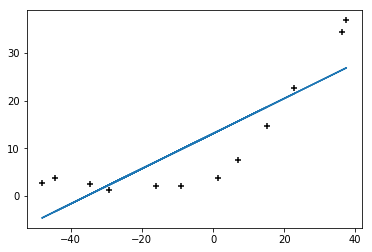

In [3]:
parte1()

In [ ]:
def funCoste(theta,X,Y,reg):

    m = Y.shape[0]
    theta_aux = np.array(theta)

    theta_aux[0] = 0
    
    coste = (sum((X.dot(theta) - Y)**2) + (reg * sum(theta_aux**2)))/(2*m)
    gradiente = ((X.dot(theta) - Y).dot(X) + (reg*theta_aux))/m
    
    return coste, gradiente
      

def parte2():
    
    data = loadmat('ex5data1.mat') #Cargamos los ejemplos de entrenamiento
    X = data['X']
    Y = data['y'] 
    Y = np.array(Y.T)[0]    
    
    Xval = data['Xval'] #Cargamos los ejemplos de validación
    Yval = data['yval'] 
    Yval = np.array(Yval.T)[0]  
    
    unos = np.ones([X.shape[0],1])
    _X = np.concatenate((unos,X),axis=1)
    unos = np.ones([Xval.shape[0],1])
    _Xval = np.concatenate((unos,Xval),axis=1)
    
    theta = np.ones((2))
    reg = 0
    error = [] #Error entrenamiento
    errorVal = [] #Error validadción
    
    for i in range(X.shape[0]): #Entrenamos para los subconjuntos de entrenamiento
        
        X_i = _X[0:i+1]
        Y_i = Y[0:i+1]

        theta_fin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(X_i,Y_i,reg),
                        method='TNC', jac=True, options={'maxiter':30})

        error.append(funCoste(theta_fin.x, X_i, Y_i, reg)[0]) #Obtenemos el error de entrenamiento
        errorVal.append(funCoste(theta_fin.x, _Xval, Yval, reg)[0]) #Obtenemos el error de validacion
     
        
    plt.plot(np.arange(1, X.shape[0]+1, 1), error) #Representamos
    plt.plot(np.arange(1, X.shape[0]+1, 1), errorVal)
        
    return 0


def generaDatos(X,p):


    Xaux = np.array(X)
    
    for i in range(p-1):
        
        X = np.concatenate((X,Xaux**(i+2)),axis=1)
    
    return X

def normaliza(X):
    

    mu = np.mean(X,axis=0)
    mu = mu.reshape(mu.shape[0],1)

    sigma = np.std(X,axis=0)
    sigma = sigma.reshape(sigma.shape[0],1)
    
    
    X = X -mu.T

    
    X = X/sigma.T
    
    return X,mu,sigma
    
    

 
def parte3():
    
    #Almacenamos los datos leídos en X, Y.
    data = loadmat('ex5data1.mat')
    Xi = data['X']
    Y = data['y'] 
    Y = np.array(Y.T)[0]  #Pasa a ser un array 1dimensional

    X = generaDatos(Xi,8) #Aumentamos el número de atributos

    X,mu,sigma = normaliza(X) #Normalizamos los atributos
    
    _X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)# Añadimos la columna de 1s al principio
    
    theta = np.zeros((_X.shape[1]))#Thetas 

    reg = 0 #Factor regularización
    
    #Función que entrena la red neuronal
    fmin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(_X,Y,reg),
                        method='TNC', jac=True, options={'maxiter':2000})

    #Nuevos datos de entrada
    Xaux = np.arange(min(Xi),max(Xi),0.05)
    X = Xaux.reshape(Xaux.shape[0],1)
    X = generaDatos(X,8)
    X = (X-mu.T)/sigma.T
    X = np.concatenate((np.ones([X.shape[0],1]),X),axis=1)
    
    #Graficamos
    plt.scatter(Xi,Y,marker='X', c='k')
    plt.plot(Xaux, X.dot(fmin.x))
    
    
    Xval = data['Xval']
    Yval = data['yval'] 
    Yval = np.array(Yval.T)[0]  
    
    Xval = generaDatos(Xval,8)

    Xval = (Xval-mu.T)/sigma.T
    
    unos = np.ones([Xval.shape[0],1])
    _Xval = np.concatenate((unos,Xval),axis=1)
    
    error = []
    errorVal = []

    
    for i in range(Xi.shape[0]):
        
        X_i = _X[0:i+1]
        Y_i = Y[0:i+1]

        theta_fin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(X_i,Y_i,reg),
                        method='TNC', jac=True, options={'maxiter':2000})

        error.append(funCoste(theta_fin.x, X_i, Y_i, reg)[0])
        errorVal.append(funCoste(theta_fin.x, _Xval, Yval, reg)[0])

    plt.figure()
    plt.plot(np.arange(1, Xi.shape[0]+1, 1), error)
    plt.plot(np.arange(1, Xi.shape[0]+1, 1), errorVal)
    
    
def parte4():
    
    data = loadmat('ex5data1.mat')
    
    X = data['X']
    Y = data['y'] 
    Y = np.array(Y.T)[0]
    
    Xval = data['Xval']
    Yval = data['yval']
    Yval = np.array(Yval.T)[0]
    
    lamb = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]

    _X = generaDatos(X,8)
    _X,mu,sigma = normaliza(_X)
    _X = np.concatenate((np.ones([X.shape[0],1]),_X),axis=1)
    
    _Xval = generaDatos(Xval,8)
    _Xval = (_Xval - mu.T)/sigma.T
    _Xval = np.concatenate((np.ones([Xval.shape[0],1]),_Xval),axis=1)

    
    error = []
    errorVal = []  
    theta = np.zeros((_X.shape[1]))

    for i in range(len(lamb)):
        
        theta_fin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(_X,Y,lamb[i]),
                        method='TNC', jac=True, options={'maxiter':2000})
        
        error.append(funCoste(theta_fin.x, _X, Y, 0)[0])

        errorVal.append(funCoste(theta_fin.x, _Xval, Yval, 0)[0])
        

    plt.plot(lamb, error)
    plt.plot(lamb, errorVal)
    
    Xtest = data['Xtest']
    Ytest = data['ytest']
    Ytest = np.array(Ytest.T)[0]
    
    _Xtest = generaDatos(Xtest,8)
    _Xtest = (_Xtest - mu.T)/sigma.T
    _Xtest = np.concatenate((np.ones([Xtest.shape[0],1]),_Xtest),axis=1)
    
    theta_fin = opt.minimize(fun=funCoste, x0=theta, 
                        args=(_X,Y,3),
                        method='TNC', jac=True, options={'maxiter':2000})
    
    error_test = funCoste(theta_fin.x, _Xtest, Ytest, 0)[0]
    
    print("Error con lambda a 3: ")
    print(error_test)
        

   

    
parte4()